<a href="https://colab.research.google.com/github/eyaJLIDI/churn_prediction_NL/blob/main/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Section 1** : Business Understanding

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 22.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=0b88125ba8bc8171f3814521cd01903d863577e3925b0d41152ecdcd4c1fdd1e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql import functions as F
from pyspark.sql import Window
import warnings
warnings.simplefilter(action='ignore')
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 800)
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier ,  DecisionTreeClassifier , LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [ ]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("NL+ churn prediction") \
        .getOrCreate()


# **Data** **preprocessing**

In [ ]:
#Read the dataset
df_data = spark.read.csv("export_dataframe.csv", header = True, inferSchema = True)
#df2 = spark.read.csv('data-SIMS.csv', header = True, inferSchema = True)
#Print dataset schema
df_data.printSchema()

root
 |-- CLT_REF: integer (nullable = true)
 |-- card_number: long (nullable = true)
 |-- AGE: double (nullable = true)
 |-- NOMBRE_CONTRAT_IR_SCO: double (nullable = true)
 |-- NOMBRE_CONTRAT_IR_ETU: double (nullable = true)
 |-- NOMBRE_CONTRAT_NA: double (nullable = true)
 |-- NOMBRE_CONTRAT_NMS: double (nullable = true)
 |-- NOMBRE_GRAT: double (nullable = true)
 |-- NOMBRE_SOL: double (nullable = true)
 |-- NOMBRE_AME: double (nullable = true)
 |-- ADR_CODE_POSTAL: integer (nullable = true)
 |-- PORTEUR_PAYEUR: integer (nullable = true)
 |-- PROFIL_IMPAYE: string (nullable = true)
 |-- SEXE: string (nullable = true)
 |-- CLT_SOLLICITATION_IND: string (nullable = true)
 |-- DATE_DEBUT: timestamp (nullable = true)
 |-- DATE_FIN: timestamp (nullable = true)
 |-- PROFIL_TARIFAIRE17: string (nullable = true)
 |-- CLT_SEL_IND: double (nullable = true)
 |-- MEDIA: string (nullable = true)
 |-- CLT_SOLLICITATION_IDFM_IND: string (nullable = true)
 |-- TYPE_RESIL: string (nullable = true)


In [ ]:
#Get number of rows and columns
print((df_data.count(), len(df_data.columns)))

(265483, 50)


In [ ]:
numeric_features = [t[0] for t in df_data.dtypes if (t[1] == 'double') | (t[1] == 'int') | (t[1] == 'bigint')]
df_data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CLT_REF,265483,2.5164806102014065E7,9416158.36263721,436,34333877
card_number,265483,1.9339434563720841E9,1.2968092390941808E9,72092200,3302768144
AGE,265320,41.119203226292775,16.69870031059291,4.0,175.0
NOMBRE_CONTRAT_IR_SCO,3255,1.0,0.0,1.0,1.0
NOMBRE_CONTRAT_IR_ETU,5473,1.0,0.0,1.0,1.0
NOMBRE_CONTRAT_NA,18312,1.0,0.0,1.0,1.0
NOMBRE_CONTRAT_NMS,54204,1.0,0.0,1.0,1.0
NOMBRE_GRAT,1277,1.0203602192638999,0.1412845078083948,1.0,2.0
NOMBRE_SOL,1823,1.007131102578168,0.08416730915926188,1.0,2.0


In [ ]:
from pyspark.sql.functions import avg

def mean_of_pyspark_columns(df_data, numeric_cols, verbose=False):
    col_with_mean=[]
    for col in numeric_cols:
        mean_value = df_data.select(avg(df_data[col]))
        avg_col = mean_value.columns[0]
        res = mean_value.rdd.map(lambda row : row[avg_col]).collect()
        
        if (verbose==True): print(mean_value.columns[0], "\t", res[0])
        col_with_mean.append([col, res[0]])    
    return col_with_mean

In [ ]:
#Fill missing values for mean
from pyspark.sql.functions import when, lit

def fill_missing_with_mean(df_data, numeric_cols):
    col_with_mean = mean_of_pyspark_columns(df_data, numeric_cols) 
    
    for col, mean in col_with_mean:
        df_data = df_data.withColumn(col, when(df_data[col].isNull()==True, 
        lit(mean)).otherwise(df_data[col]))
        
    return df_data

In [ ]:
df_data = fill_missing_with_mean(df_data, numeric_features)

In [ ]:
df_data.dtypes

[('CLT_REF', 'double'),
 ('card_number', 'double'),
 ('AGE', 'double'),
 ('NOMBRE_CONTRAT_IR_SCO', 'double'),
 ('NOMBRE_CONTRAT_IR_ETU', 'double'),
 ('NOMBRE_CONTRAT_NA', 'double'),
 ('NOMBRE_CONTRAT_NMS', 'double'),
 ('NOMBRE_GRAT', 'double'),
 ('NOMBRE_SOL', 'double'),
 ('NOMBRE_AME', 'double'),
 ('ADR_CODE_POSTAL', 'double'),
 ('PORTEUR_PAYEUR', 'double'),
 ('PROFIL_IMPAYE', 'string'),
 ('SEXE', 'string'),
 ('CLT_SOLLICITATION_IND', 'string'),
 ('DATE_DEBUT', 'timestamp'),
 ('DATE_FIN', 'timestamp'),
 ('PROFIL_TARIFAIRE17', 'string'),
 ('CLT_SEL_IND', 'double'),
 ('MEDIA', 'string'),
 ('CLT_SOLLICITATION_IDFM_IND', 'string'),
 ('TYPE_RESIL', 'string'),
 ('ACTEUR_RESIL', 'string'),
 ('MONTANT23', 'double'),
 ('ANCIENNETE_NLP', 'double'),
 ('CONTRATS_PRECEDENTS', 'double'),
 ('STATUT', 'string'),
 ('NOMBRE_DEPT_RESIDENCE_MOIS', 'double'),
 ('DT_MEAN', 'double'),
 ('ECART_TYPE', 'double'),
 ('VOL_INTERACTION', 'double'),
 ('VOL_EVT', 'double'),
 ('performance', 'double'),
 ('VOL_EVT_SI

## **la colonne TARGET "churn"**

In [ ]:
df_data = df_data.withColumnRenamed("STATUT","CHURN")

In [ ]:
df_data.select("CHURN").distinct().show()

+--------------------+
|               CHURN|
+--------------------+
|         Contentieux|
|      Résilié client|
|              Retard|
|Résilié gestionnaire|
|  Résilié COMUTITRES|
|            Suspendu|
|               Actif|
+--------------------+



In [ ]:
df_data = df_data.withColumn( "CHURN" , F.when(((F.col("CHURN") == "Résilié client") | (F.col("CHURN") == "Résilié gestionnaire") | (F.col("CHURN") == "Résilié COMUTITRES") | (F.col("CHURN") == "Suspendu")), F.lit("churn")).otherwise("non churn"))

In [ ]:
df_data.select("CHURN").distinct().show()

+---------+
|    CHURN|
+---------+
|non churn|
|    churn|
+---------+



In [ ]:
print((df_data.count(), len(df_data.columns)))

(265483, 50)


In [ ]:
df_data = df_data.dropDuplicates()

- Below code shows statistics for each numerical feature.

In [ ]:
#Loop through each of numerical value and print statistics
for col_name in numeric_features:
    print(f"Statistics for column: {col_name}")
    df_data.describe([col_name]).show()

Statistics for column: CLT_REF


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

- Below code shows the value count for each categorical column in the dataset

In [ ]:
categorical_columns = [c for c, t in df_data.dtypes if t =='string' ]

for col_name in categorical_columns:
    print(f"Value counts for column: {col_name}")
    df_data.groupBy(col_name).count().orderBy('count', ascending=False).show()

Value counts for column: artist
+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows

Value counts for column: auth
+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+

Value counts for column: firstName
+---------+-----+
|firstName|count|
+---------+-----+
|   Payton| 

In [ ]:
churn_column = ['CHURN']

for col_name in churn_column:
    print(f"Value counts for column: {col_name}")
    df_data.groupBy(col_name).count().orderBy('count', ascending=False).show()

Value counts for column: CHURN
+---------+------+
|    CHURN| count|
+---------+------+
|non churn|236341|
|    churn| 29142|
+---------+------+



# **Etude de corrélation**


## transformation des colonnes string

In [ ]:
df_data = df_data.na.fill("unknown")

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [ ]:
df_corr = df_data.select("*")

In [ ]:
categorical_columns = [c for c, t in df_corr.dtypes if t =='string' ]
print(categorical_columns)

['PROFIL_IMPAYE', 'SEXE', 'CLT_SOLLICITATION_IND', 'PROFIL_TARIFAIRE17', 'MEDIA', 'CLT_SOLLICITATION_IDFM_IND', 'TYPE_RESIL', 'ACTEUR_RESIL', 'CHURN', 'profil_tarifaire46']


In [ ]:
df_corr = df_corr.drop('DATE_DEBUT','DATE_FIN','date')

In [ ]:
indexer = StringIndexer(inputCols=['PROFIL_IMPAYE', 'SEXE', 'CLT_SOLLICITATION_IND', 'PROFIL_TARIFAIRE17', 'MEDIA', 'CLT_SOLLICITATION_IDFM_IND', 'TYPE_RESIL', 'ACTEUR_RESIL', 'CHURN', 'profil_tarifaire46'],outputCols=['PROFIL_IMPAYE_index', 'SEXE_index', 'CLT_SOLLICITATION_IND_index', 'PROFIL_TARIFAIRE17_index', 'MEDIA_index', 'CLT_SOLLICITATION_IDFM_IND_index', 'TYPE_RESIL_index', 'ACTEUR_RESIL_index', 'CHURN_index', 'profil_tarifaire46_index'])
indexed = indexer.fit(df_corr).transform(df_corr)

In [ ]:
indexed.printSchema()

root
 |-- CLT_REF: double (nullable = true)
 |-- card_number: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- NOMBRE_CONTRAT_IR_SCO: double (nullable = true)
 |-- NOMBRE_CONTRAT_IR_ETU: double (nullable = true)
 |-- NOMBRE_CONTRAT_NA: double (nullable = true)
 |-- NOMBRE_CONTRAT_NMS: double (nullable = true)
 |-- NOMBRE_GRAT: double (nullable = true)
 |-- NOMBRE_SOL: double (nullable = true)
 |-- NOMBRE_AME: double (nullable = true)
 |-- ADR_CODE_POSTAL: double (nullable = true)
 |-- PORTEUR_PAYEUR: double (nullable = true)
 |-- PROFIL_IMPAYE: string (nullable = false)
 |-- SEXE: string (nullable = false)
 |-- CLT_SOLLICITATION_IND: string (nullable = false)
 |-- PROFIL_TARIFAIRE17: string (nullable = false)
 |-- CLT_SEL_IND: double (nullable = true)
 |-- MEDIA: string (nullable = false)
 |-- CLT_SOLLICITATION_IDFM_IND: string (nullable = false)
 |-- TYPE_RESIL: string (nullable = false)
 |-- ACTEUR_RESIL: string (nullable = false)
 |-- MONTANT23: double (nullable = tr

In [ ]:
indexed = indexed.drop('PROFIL_IMPAYE', 'SEXE', 'CLT_SOLLICITATION_IND', 'PROFIL_TARIFAIRE17', 'MEDIA', 'CLT_SOLLICITATION_IDFM_IND', 'TYPE_RESIL', 'ACTEUR_RESIL', 'CHURN', 'profil_tarifaire46')

In [ ]:
indexed.show(100)

+-----------+-------------+----+---------------------+---------------------+-----------------+------------------+------------------+-----------------+----------+---------------+--------------+------------------+---------+--------------+-------------------+--------------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+----------------------+--------------+-----------------+------------------------+------------------+-----------------+-------------------------+-----------------+-----------------+--------------------+-----------------+-----------------+------------------+--------------+-------------------+----------+---------------------------+------------------------+-----------+--------------------------------+----------------+------------------+-----------+------------------------+
|    CLT_REF|  card_number| AGE|NOMBRE_CONTRAT_IR_SCO|NOMBRE_CONTRAT_IR_ETU|NOMBRE_CONTRAT_NA|NOMBRE_CONTRAT_NMS|       NOMBRE_GR

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation


# convert to vector column first
vector_col = "corr_features"
assembler2 = VectorAssembler(inputCols=indexed.columns, outputCol=vector_col)
indexed_vector = assembler2.transform(indexed).select(vector_col)

In [ ]:
matrix = Correlation.corr(indexed_vector, vector_col).collect()[0][0]

In [ ]:
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, 0.05339040044226047, -0.2233425690990001, nan, nan, nan, nan, -0.004660672207463373, 0.0011277629964274278, nan, 0.02300350320041711, -0.16672133757724222, -0.024498648443300367, -0.019601792595260095, 0.00683753545889017, -0.019670967478351162, 0.00816670272715283, 0.02022042458590053, 0.0025371825059066675, 0.000716335287003874, 0.01360261184954436, -0.002515356301054502, -0.0018739748544355842, 0.001949922988745904, nan, -0.0019532044672237975, 0.0017738906586357039, 0.005330642299630929, 0.004857538296887141, nan, 0.00019216346244856455, 0.0008938799772502435, nan, -0.0019460150300387874, 0.00973148109666916, 0.011433131767630438, nan, 0.014168345886207847, 0.028758920604696786, 0.01909160560488114, 0.012235502377996936, 0.07962313419590426, -0.0068545630660515515, 0.007657527736722638, 0.0057974440645424865, 0.027943858679728397, 0.013194683184859436], [0.05339040044226047, 1.0, -0.009591545220393058, nan, nan, nan, nan, -0.0027199454714020555, -0.0035381006931993497, nan, 

In [ ]:
Columns = ['CLT_REF', 'card_number', 'AGE', 'NOMBRE_CONTRAT_IR_SCO',
       'NOMBRE_CONTRAT_IR_ETU', 'NOMBRE_CONTRAT_NA', 'NOMBRE_CONTRAT_NMS',
       'NOMBRE_GRAT', 'NOMBRE_SOL', 'NOMBRE_AME', 'ADR_CODE_POSTAL',
       'PORTEUR_PAYEUR', 'PROFIL_IMPAYE', 'SEXE', 'CLT_SOLLICITATION_IND', 'PROFIL_TARIFAIRE17', 'CLT_SEL_IND', 'MEDIA',
       'CLT_SOLLICITATION_IDFM_IND', 'TYPE_RESIL', 'ACTEUR_RESIL', 'MONTANT23',
       'ANCIENNETE_NLP', 'CONTRATS_PRECEDENTS', 'CHURN',
       'NOMBRE_DEPT_RESIDENCE_MOIS', 'DT_MEAN', 'ECART_TYPE',
       'VOL_INTERACTION', 'VOL_EVT', 'performance', 'VOL_EVT_SIMPLE',
       'VOL_INTERACTION_SIMPLE', 'DT_MEAN_SIMPLE', 'VOL_EVT_STANDARD',
       'VOL_INTERACTION_STANDARD', 'DT_MEAN_STANDARD', 'VOL_EVT_COMPLIQUE',
       'VOL_INTERACTION_COMPLIQUE', 'DT_MEAN_COMPLIQUE', 'VOL_EVT_BLOQ',
       'VOL_INTERACTION_BLOQ', 'DT_MEAN_BLOQ', 'date', 'profil_tarifaire46',
       'nombre', 'montant48', 'montant_offert']

In [ ]:
dataF = spark.createDataFrame(corrmatrix,Columns)
dataF.show()

IndexError: ignored

In [ ]:
import pyspark.pandas as ps
df = df_data.toPandas()

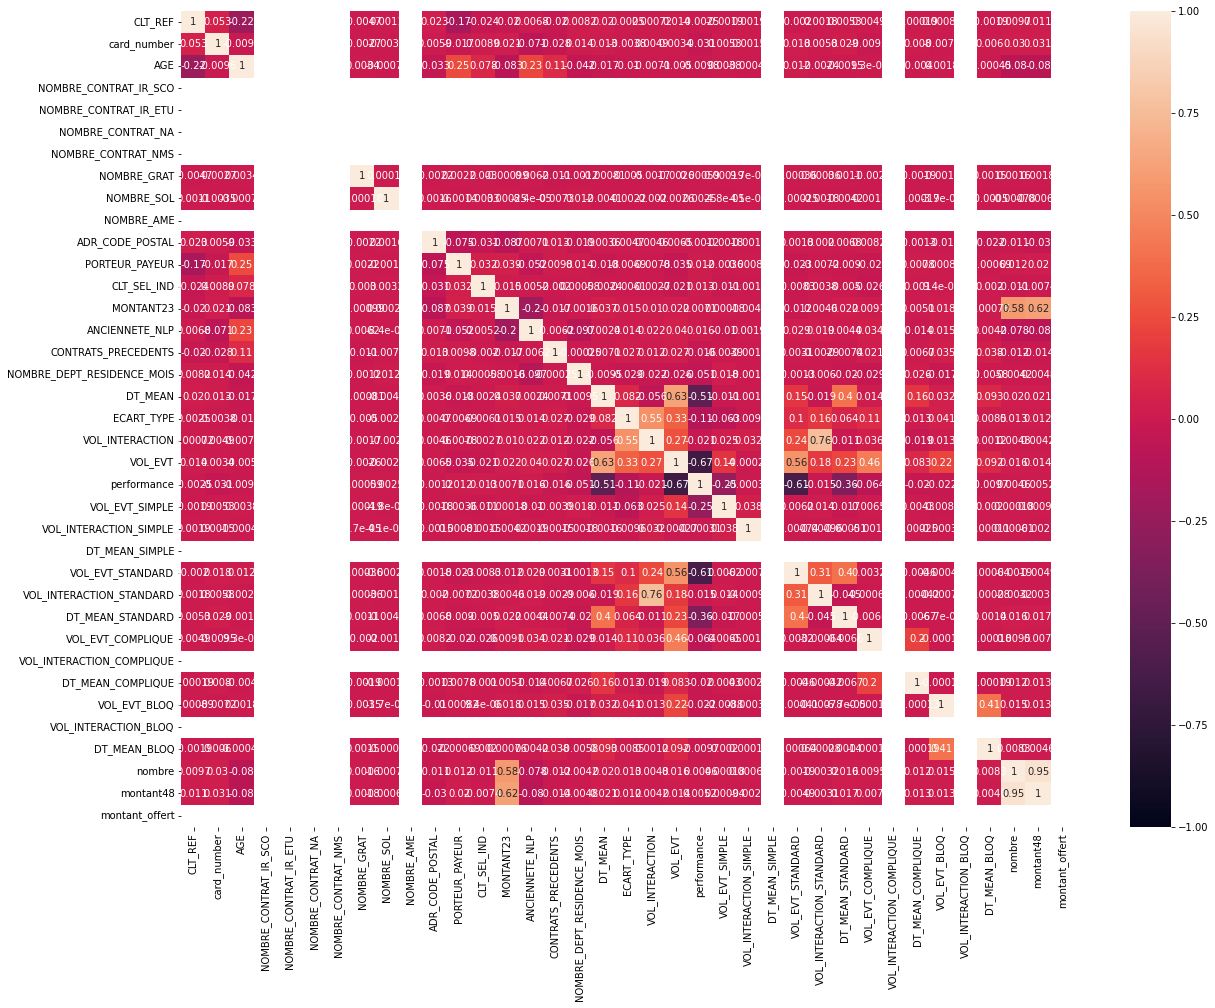

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True)

In [ ]:
df = df.drop(["performance","VOL_EVT","DT_MEAN","VOL_INTERACTION","VOL_INTERACTION_SIMPLE","DATE_DEBUT","DATE_FIN"],axis=1)
df = df.drop(['VOL_EVT_SIMPLE',
       'DT_MEAN_SIMPLE', 'VOL_EVT_STANDARD', 'VOL_INTERACTION_STANDARD',
       'DT_MEAN_STANDARD','ECART_TYPE'],axis=1)

In [ ]:
data = df[['CLT_REF','nombre']].groupby('CLT_REF').mean()
data = data.reset_index()
data.rename(columns = {'nombre': 'trajets_moyen'}, inplace = True)
data = data.merge(df, on='CLT_REF')

In [ ]:
data['evol_trajet'] = 0
data.loc[(data['nombre'] > data['trajets_moyen']*2 ) | (data['nombre'] < data['trajets_moyen']*0.5), "evol_trajet"] = 1

In [ ]:
data[data['evol_trajet'] == 1]

,CLT_REF,trajets_moyen,card_number,AGE,NOMBRE_CONTRAT_IR_SCO,NOMBRE_CONTRAT_IR_ETU,NOMBRE_CONTRAT_NA,NOMBRE_CONTRAT_NMS,NOMBRE_GRAT,NOMBRE_SOL,NOMBRE_AME,ADR_CODE_POSTAL,PORTEUR_PAYEUR,PROFIL_IMPAYE,SEXE,CLT_SOLLICITATION_IND,PROFIL_TARIFAIRE17,CLT_SEL_IND,MEDIA,CLT_SOLLICITATION_IDFM_IND,TYPE_RESIL,ACTEUR_RESIL,MONTANT23,ANCIENNETE_NLP,CONTRATS_PRECEDENTS,CHURN,NOMBRE_DEPT_RESIDENCE_MOIS,VOL_EVT_COMPLIQUE,VOL_INTERACTION_COMPLIQUE,DT_MEAN_COMPLIQUE,VOL_EVT_BLOQ,VOL_INTERACTION_BLOQ,DT_MEAN_BLOQ,date,profil_tarifaire46,nombre,montant48,montant_offert,evol_trajet
12,2234.0,6.163756,1.276281e+09,72.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,93500.0,1.0,N,M,O,Plein Tarif,1.0,Face Ã Face,N,unknown,unknown,1.49,42.0,5.263413,non churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-01-01,ALL_PUBLIC,1.0,149.0,0.0,1
14,2235.0,6.163756,1.276281e+09,68.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,93500.0,1.0,N,M,O,Plein Tarif,1.0,Face Ã Face,N,unknown,unknown,1.49,42.0,5.263413,non churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-01-01,ALL_PUBLIC,1.0,149.0,0.0,1
19,4117.0,12.500000,3.243359e+09,81.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,75014.0,1.0,N,M,N,Plein Tarif,1.0,Internet,N,unknown,unknown,8.94,47.0,5.263413,non churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-02-01,ALL_PUBLIC,6.0,894.0,0.0,1
29,8578.0,6.442504,3.246521e+09,70.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,92120.0,1.0,N,F,N,Plein Tarif,1.0,Face Ã Face,N,unknown,unknown,2.98,41.0,5.263413,non churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-03-01,ALL_PUBLIC,2.0,298.0,0.0,1
31,9520.0,6.163756,3.278832e+09,65.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,75012.0,1.0,N,F,O,Plein Tarif,1.0,Face Ã Face,N,unknown,unknown,1.49,4.0,4.000000,non churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-01-01,ALL_PUBLIC,1.0,149.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265354,33596373.0,18.400000,3.246787e+09,22.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,75002.0,0.0,N,M,N,Plein Tarif,1.0,Internet,N,unknown,unknown,8.94,10.0,2.000000,non churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-01-01,ALL_PUBLIC,7.0,894.0,0.0,1
265356,33596373.0,18.400000,3.246787e+09,22.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,75002.0,1.0,N,M,N,Plein Tarif,1.0,Internet,N,unknown,unknown,8.94,10.0,2.000000,non churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-01-01,ALL_PUBLIC,7.0,894.0,0.0,1
265374,33618691.0,5.000000,3.278872e+09,22.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,75012.0,1.0,N,F,O,Plein Tarif,0.0,unknown,N,unknown,unknown,1.49,14.0,5.263413,non churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-03-01,ALL_PUBLIC,1.0,149.0,0.0,1
265462,34210101.0,8.218341,3.243741e+09,26.0,1.0,1.0,1.0,1.0,1.02036,1.007131,1.0,91350.0,0.0,O,M,O,Plein Tarif,1.0,unknown,O,unknown,unknown,2.98,43.0,5.263413,churn,1.0,8.544718,1.0,9.098176,9.072593,1.0,13.396296,2021-01-01,ALL_PUBLIC,2.0,298.0,0.0,1


In [ ]:
data.drop(columns=['trajets_moyen'],inplace=True)

In [ ]:
data.columns

Index(['CLT_REF', 'card_number', 'AGE', 'NOMBRE_CONTRAT_IR_SCO',
       'NOMBRE_CONTRAT_IR_ETU', 'NOMBRE_CONTRAT_NA', 'NOMBRE_CONTRAT_NMS',
       'NOMBRE_GRAT', 'NOMBRE_SOL', 'NOMBRE_AME', 'ADR_CODE_POSTAL',
       'PORTEUR_PAYEUR', 'PROFIL_IMPAYE', 'SEXE', 'CLT_SOLLICITATION_IND',
       'PROFIL_TARIFAIRE17', 'CLT_SEL_IND', 'MEDIA',
       'CLT_SOLLICITATION_IDFM_IND', 'TYPE_RESIL', 'ACTEUR_RESIL', 'MONTANT23',
       'ANCIENNETE_NLP', 'CONTRATS_PRECEDENTS', 'CHURN',
       'NOMBRE_DEPT_RESIDENCE_MOIS', 'VOL_EVT_COMPLIQUE',
       'VOL_INTERACTION_COMPLIQUE', 'DT_MEAN_COMPLIQUE', 'VOL_EVT_BLOQ',
       'VOL_INTERACTION_BLOQ', 'DT_MEAN_BLOQ', 'date', 'profil_tarifaire46',
       'nombre', 'montant48', 'montant_offert', 'evol_trajet'],
      dtype='object')

In [ ]:
df_temps = data[['CLT_REF','CHURN','date']].groupby(['CLT_REF'])['CHURN','date'].shift(-1)

In [ ]:
df_temps.rename(columns={'CHURN':'CHURN_shift','date':'date_shift'},inplace=True)

In [ ]:
data = df_temps.join(data)
data

In [ ]:
data.drop(columns=['targCHURNet','date','date_shift','CLT_REF','card_number'],inplace=True)
data.columns

In [ ]:
data.rename(columns={'MONTANT':'facture','nombre':'nb_trajet_effectué'},inplace=True)

In [ ]:
data.dropna(subset=['target_shift'],inplace=True)

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(method='pearson'), vmin=-1, vmax=1, annot=True)

# Analyse des données


In [ ]:
data.columns

In [ ]:
data['target_shift'].value_counts()

In [ ]:
data['target_shift'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("nombre", labelpad=14)
plt.title("nombre de target variable par category", y=1.02)

In [ ]:
100*data['target_shift'].value_counts()/len(data['target_shift'])

In [ ]:
for i, predictor in enumerate(data.drop(columns=["target_shift"])):
    plt.figure(i)
    sns.countplot(data=data, x=predictor, hue='target_shift')

# Préprocessing

In [ ]:
categoric_features = [t[0] for t in df.dtypes if t[1] == 'string']

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['age', 'sex', 'city', 'province', 'country', 'longitude', 'geo_resolution', 'date_onset_symptoms', 'date_admission_hospital', 'date_confirmation', 'symptoms', 'lives_in_Wuhan', 'travel_history_dates', 'travel_history_location', 'reported_market_exposure', 'additional_information', 'chronic_disease_binary', 'chronic_disease', 'source', 'sequence_available', 'outcome', 'date_death_or_discharge', 'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1', 'country_new', 'admin_id', 'data_moderator_initials']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'outcome', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['latitude', 'travel_history_binary']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df2)
df2 = pipelineModel.transform(df2)
selectedCols = ['label', 'features'] + cols
df2 = df2.select(selectedCols)
df2.printSchema()

In [ ]:
df2 = df2.drop('ID')
df2.printSchema()

In [ ]:
print((df2.count(), len(df2.columns)))